# A Pytorch-Based Implementation of CMR
Pytorch has a few nice features that make it a good idea for model-based research:
- It can use the GPU! If you want it to - even the fitting parts of programs, something numba can't do unless you implement the algorithm yourself.
- It can automatically compute derivatives through potentially complex programs, supporting efficient parameter optimization!
- It supports JIT-based compilation for further optimization
- It comes with an extensive, well-documented library of functions designed specifically to help construct, fit, and evaluate neural network models
- Lots of interesting tools have been built around it that could help out in lots of unexpected ways

The main thing we're interested in here is speed: we want a model that can quickly fit large datasets where presentation order is variable, normally requiring re-initializing model states and slowing simulation.

## Setup

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
%pdb

Automatic pdb calling has been turned ON


## Model
The same as our numba-based implementation, but using Pytorch's GPU-compatible tensors and the nn.Module to enable interface with Pytorch's model fitting framework.

In [2]:
class CMR(nn.Module):
    
    def __init__(self, item_count, batch_size, presentation_count, 
                 encoding_drift_rate, start_drift_rate, recall_drift_rate, 
                 shared_support, item_support, learning_rate, primacy_scale, 
                 primacy_decay, stop_probability_scale, 
                 stop_probability_growth, choice_sensitivity):
        
        super(CMR, self).__init__()

        # store initial parameters
        self.encoding_drift_rate = nn.Parameter(torch.tensor(
            [encoding_drift_rate], dtype=torch.float64, device=device))
        self.start_drift_rate = nn.Parameter(torch.tensor(
            [start_drift_rate], dtype=torch.float64, device=device))
        self.recall_drift_rate = nn.Parameter(torch.tensor(
            [recall_drift_rate], dtype=torch.float64, device=device))
        self.shared_support = nn.Parameter(torch.tensor(
            [shared_support], dtype=torch.float64, device=device))
        self.item_support = nn.Parameter(torch.tensor(
            [item_support], dtype=torch.float64, device=device))
        self.learning_rate = nn.Parameter(torch.tensor(
            [learning_rate], dtype=torch.float64, device=device))
        self.primacy_scale = nn.Parameter(torch.tensor(
            [primacy_scale], dtype=torch.float64, device=device))
        self.primacy_decay = nn.Parameter(torch.tensor(
            [primacy_decay], dtype=torch.float64, device=device))
        self.stop_probability_scale = nn.Parameter(torch.tensor(
            [stop_probability_scale], dtype=torch.float64, device=device))
        self.stop_probability_growth = nn.Parameter(torch.tensor(
            [stop_probability_growth], dtype=torch.float64, device=device))
        self.choice_sensitivity = nn.Parameter(torch.tensor(
            [choice_sensitivity], dtype=torch.float64, device=device))

        # start of the list context is initialized with state orthogonal to the
        # pre-experimental context associated with the set of items
        self.item_count = item_count
        self.context = torch.zeros(item_count + 1, dtype=torch.float64)
        self.context[-1] = 1
        self.preretrieval_context = self.context
        self.recall = torch.zeros(item_count) 
        self.retrieving = False
        self.recall_total = 0

        # predefine primacy weighting vectors
        self.primacy_weighting = primacy_scale * torch.exp(
            -primacy_decay * torch.arange(presentation_count)) + 1

        # preallocate for outcome_probabilities
        self.probabilities = torch.zeros((item_count + 1))

        # The two layers communicate with one another through two sets of 
        # associative connections represented by matrices Mfc and Mcf. Pre-
        # experimental Mfc is 1-learning_rate and pre-experimental Mcf is 
        # item_support for i=j. For i!=j, Mcf is shared_support.
        self.mfc = torch.eye(item_count, item_count+1, dtype=torch.float64) * (
            1 - learning_rate)
        self.mcf = self.mfc.T + shared_support
        for i in range(item_count):
            self.mcf[i, i] = item_support
            
        self.likelihoods = torch.ones(batch_size, item_count)
        self.encoding_index = 0
        self.items = torch.eye(item_count, item_count, dtype=torch.float64)
        self.experience(self.items)
        
    def experience(self, experiences):
        
        for i in range(len(experiences)):
            self.update_context(self.encoding_drift_rate, experiences[i])
            self.mfc = self.mfc + self.learning_rate * torch.outer(
                self.context, experiences[i]).T
            self.mcf = self.mcf + self.primacy_weighting[self.encoding_index] * (
                torch.outer(self.context, experiences[i]))
            self.encoding_index = self.encoding_index + 1
                    
    def update_context(self, drift_rate, experience=None):

        # first pre-experimental or initial context is retrieved
        if experience is not None:
            context_input = self.activations(experience, True) 
            context_input = context_input / torch.sqrt(
                torch.sum(torch.square(context_input))) # norm to length 1
        else:
            context_input = torch.zeros((self.item_count+1))
            context_input[-1] = 1

        # updated context is sum of context and input,
        # modulated by rho to have len 1 and some drift_rate
        rho = torch.sqrt(1 + torch.square(drift_rate) * (
            torch.square(self.context * context_input) - 1)) - (
            drift_rate * (self.context * context_input))
        
        self.context = (rho * self.context) + (drift_rate * context_input)
        
    def activations(self, probe, use_mfc=False):
        
        return torch.tensordot(probe, self.mfc if use_mfc else self.mcf, 1) + 10e-7
    
    def outcome_probabilities(self, activation_cue):

        activation = self.activations(activation_cue)
        activation = torch.pow(activation, self.choice_sensitivity)

        self.probabilities = torch.zeros((self.item_count + 1))
    
        self.probabilities[0] = torch.min(self.stop_probability_scale * torch.exp(
            self.recall_total * self.stop_probability_growth), 1.0  - (
                (self.item_count-self.recall_total) * 10e-7))

        for already_recalled_item in self.recall[:self.recall_total]:
            activation[int(already_recalled_item)] = 0
        self.probabilities[1:] = (
            1-self.probabilities[0]) * activation / torch.sum(activation)
        
        return self.probabilities
    
    def free_recall(self, steps=None):

        # some amount of the pre-list context is reinstated before recall
        if not self.retrieving:
            self.recall = torch.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        # we retrieve # of items left to recall if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps
        
        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to 
            # attempt recall of a studied item compute outcome probabilities 
            # and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities(self.context)
            if torch.any(outcome_probabilities[1:] > 0):
                choice = torch.sum(
                    torch.cumsum(outcome_probabilities, 0) < torch.rand(1))
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
            self.recall[self.recall_total] = choice - 1
            self.recall_total = self.recall_total + 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
            
        return self.recall[:self.recall_total]
    
    def force_recall(self, choice=None):

        if not self.retrieving:
            self.recall = torch.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total = self.recall_total + 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
            
        return self.recall[:self.recall_total]
    
    def likelihood(self, trials):
        
        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < self.item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability and simulate recalling item with this index
                self.likelihoods[trial_index, recall_index] = \
                    model.outcome_probabilities(model.context)[recall]
                
                if recall == 0:
                    break
                model.force_recall(recall)
                
            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
            
        return -torch.sum(torch.log(self.likelihoods))

## Temporal Organizational Analyses
Where we workshop how to use a Pytorch-based model.

In [3]:
import pandas as pd
from psifr import fr
import matplotlib.pyplot as plt


def temporal_organization_analyses(
    model, experiment_count, savefig=False, figsize=(15, 15), first_recall_item=None):
    """
    Visualization of the outcomes of a trio of organizational analyses of model
    performance on a free recall task.

    **Required model attributes**:
    - item_count: specifies number of items encoded into memory  
    - context: vector representing an internal contextual state  
    - experience: adding a new trace to the memory model  
    - free_recall: function that freely recalls a given number of items or 
        until recall stops  

    **Other arguments**:  
    - experiment_count: number of simulations to compute curves over  
    - savefig: whether to save or display the figure of interest

    **Returns** three plots corresponding to the contents of Figure 4 in 
    Morton & Polyn, 2016:  
    1. Recall probability as a function of serial position  
    2. Probability of starting recall with each serial position  
    3. Conditional response probability as a function of lag  
    """
    
    # encode items
    # model.experience(torch.eye(model.item_count, model.item_count, dtype=torch.float64))

    # simulate retrieval for the specified number of times, tracking results in df
    data = []
    for experiment in range(experiment_count):
        data += [[experiment, 0, 'study', i + 1, i] for i in range(model.item_count)]
    for experiment in range(experiment_count):
        if first_recall_item is not None:
            model.force_recall(first_recall_item)
        data += [[experiment, 0, 'recall', i + 1, o] for i, o in enumerate(
            model.free_recall().numpy())]
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    
    # visualizations
    # spc
    recall = fr.spc(merged)
    g = fr.plot_spc(recall)
    plt.title('Serial Position Curve')
    if savefig:
        plt.savefig('figures/spc.jpeg', bbox_inches='tight')
    else:
        plt.show()

    # P(Start Recall) For Each Serial Position
    prob = fr.pnr(merged)
    pfr = prob.query('output <= 1')
    g = fr.plot_spc(pfr).add_legend()
    plt.title('Probability of Starting Recall With Each Serial Position')
    if savefig:
        plt.savefig('figures/pfr.jpeg', bbox_inches='tight')
    else:
        plt.show()

    # Conditional response probability as a function of lag
    crp = fr.lag_crp(merged)
    g = fr.plot_lag_crp(crp)
    plt.title('Conditional Response Probability')
    if savefig:
        plt.savefig('figures/crp.jpeg', bbox_inches='tight')
    else:
        plt.show()

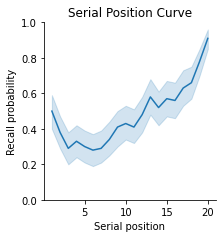

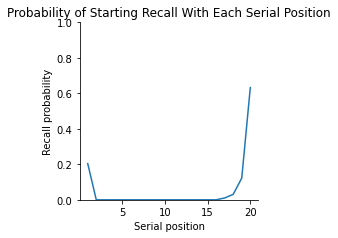

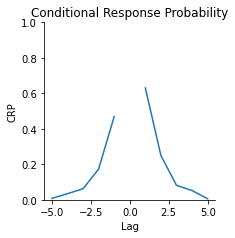

In [4]:
parameters = {
    'item_count': torch.tensor(20),
    'batch_size': torch.tensor(20),
    'presentation_count': torch.tensor(20),
    'encoding_drift_rate': torch.tensor(.8),
    'start_drift_rate': torch.tensor(.7),
    'recall_drift_rate': torch.tensor(.8),
    'shared_support': torch.tensor(0.01),
    'item_support': torch.tensor(1.0),
    'learning_rate': torch.tensor(.3),
    'primacy_scale': torch.tensor(1.),
    'primacy_decay': torch.tensor(1.),
    'stop_probability_scale': torch.tensor(0.01),
    'stop_probability_growth': torch.tensor(0.3),
    'choice_sensitivity': torch.tensor(3.0),
}

experiment_count = 100

model = CMR(**parameters)
temporal_organization_analyses(model, experiment_count)

## Data Preparation
A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. 

In [5]:
import scipy.io as sio
import pandas as pd
from psifr import fr


class Murd62(Dataset):
    
    def __init__(self, path, dataset_index):
        
        # load all the data
        matfile = sio.loadmat(path, squeeze_me=True)
        murd_data = [matfile['data'].item()[0][i].item() for i in range(3)]

        # encode dataset into psifr format
        trials, self.list_length, subjects = murd_data[dataset_index][:3]
        trials = trials.astype('int64')

        data = []
        for trial_index, trial in enumerate(trials):

            # every time the subject changes, reset list_index
            if not data or data[-1][0] != subjects[trial_index]:
                list_index = 0
            list_index += 1

            # add study events
            for i in range(self.list_length):
                data += [[subjects[trial_index], 
                          list_index, 'study', i+1, i+1]]

            # add recall events
            for recall_index, recall_event in enumerate(trial):
                if recall_event != 0:
                    data += [[subjects[trial_index], list_index, 
                              'recall', recall_index+1, recall_event]]

        data = pd.DataFrame(data, columns=[
            'subject', 'list', 'trial_type', 'position', 'item'])
        self.trials = torch.from_numpy(trials)
        self.events = fr.merge_free_recall(data)        

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        return self.trials[idx]

In [6]:
murd_data = Murd62('../data/MurdData_clean.mat', 0)
murd_data.events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Optimizing Model Parameters
To train a model, we need a loss function and an optimizer with our model.

In [7]:
batch_size = 80

parameters = {
    'item_count': torch.tensor(20),
    'batch_size': torch.tensor(batch_size),
    'presentation_count': torch.tensor(20),
    'encoding_drift_rate': torch.tensor(.8),
    'start_drift_rate': torch.tensor(.7),
    'recall_drift_rate': torch.tensor(.8),
    'shared_support': torch.tensor(0.01),
    'item_support': torch.tensor(1.0),
    'learning_rate': torch.tensor(.3),
    'primacy_scale': torch.tensor(1.),
    'primacy_decay': torch.tensor(1.),
    'stop_probability_scale': torch.tensor(0.01),
    'stop_probability_growth': torch.tensor(0.3),
    'choice_sensitivity': torch.tensor(3.0),
}

dataloader = DataLoader(murd_data, batch_size=batch_size)
model = CMR(**parameters).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        loss = Variable(model.likelihood(X), requires_grad=True)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------


NameError: name 'loss_fn' is not defined

> <ipython-input-9-291d5e9d8d95>(4)<module>()
      1 epochs = 5
      2 for t in range(epochs):
      3     print(f"Epoch {t+1}\n-------------------------------")
----> 4     train(dataloader, model, loss_fn, optimizer)
      5 print("Done!")

